## 1) Imports & Setup

In [56]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
CV_FOLDS = 5

## 2) Load Data

In [31]:
df = pd.read_csv('loan_data.csv')
print(df.shape)
df.head()

(45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## 3) Quick Overview

In [32]:
print('Data types:\n', df.dtypes)
print("\nTarget distribution:")
print(df['loan_status'].value_counts(dropna=False))
print("\nMissing values per column:")
print(df.isna().sum())

Data types:
 person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

Target distribution:
loan_status
0    35000
1    10000
Name: count, dtype: int64

Missing values per column:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent            

## 4) EDA | Class Balance

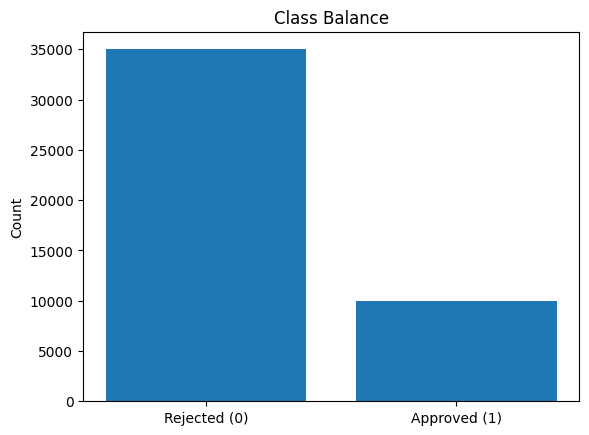

In [33]:
vals = df['loan_status'].value_counts()
plt.figure()
plt.bar(['Rejected (0)', 'Approved (1)'], vals.values)
plt.title('Class Balance')
plt.ylabel('Count')
plt.show()

## 5) Outlier Inspection — Boxplots

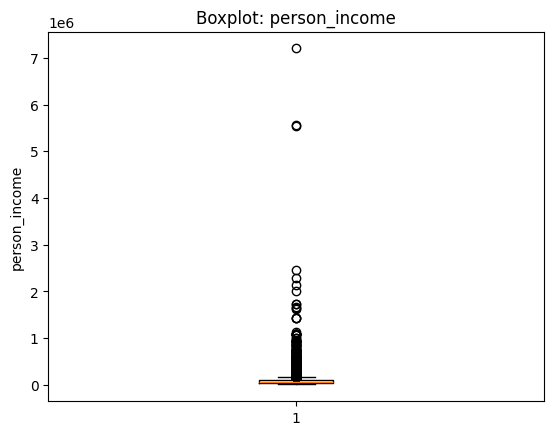

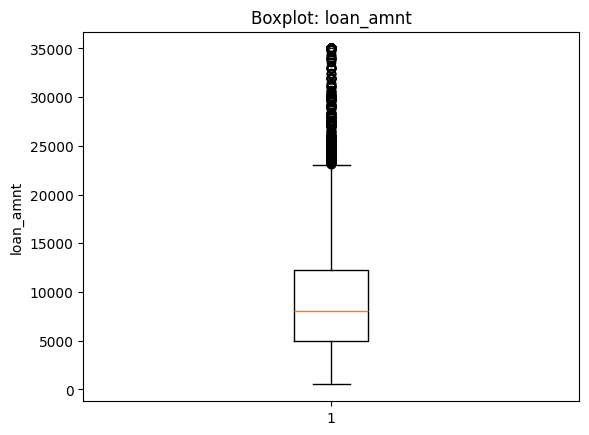

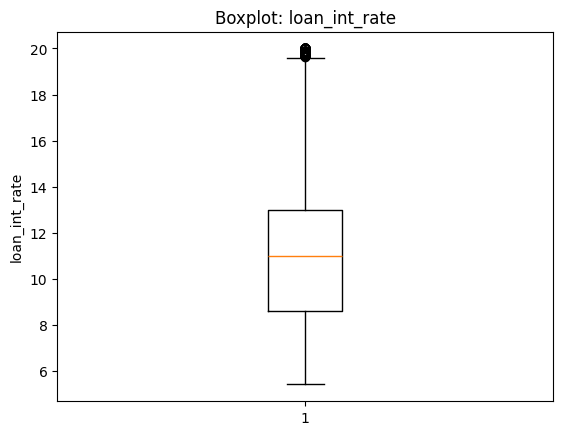

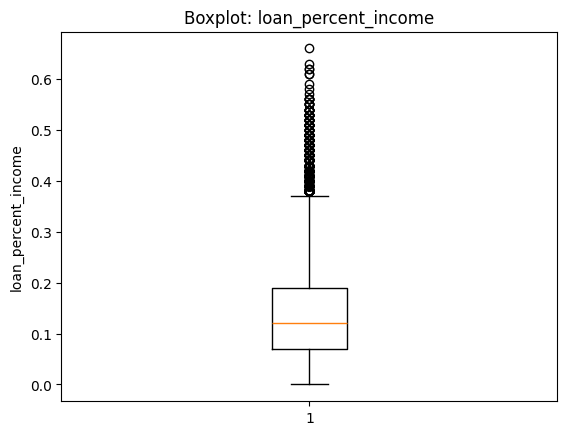

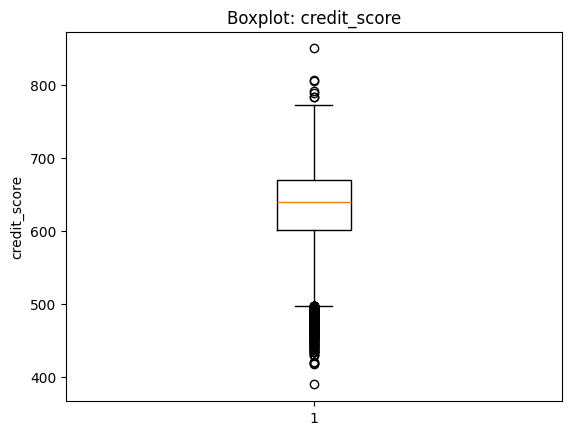

In [52]:
for col in ['person_income','loan_amnt','loan_int_rate','loan_percent_income','credit_score']:
    if col in df.columns:
        plt.figure()
        bp = plt.boxplot(df[col].dropna().values, vert=True, showfliers=True)
        plt.title(f'Boxplot: {col}')
        plt.ylabel(col)
        plt.show()

## 6) EDA | Numeric Summary & Percentiles

In [35]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
1%,21.000000,1.787595e+04,0.000000,1138.870000,5.420000,0.020000,2.000000,497.000000,0.000000
5%,22.000000,2.836670e+04,0.000000,2000.000000,6.170000,0.030000,2.000000,539.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
95%,39.000000,1.667547e+05,17.000000,24000.000000,16.000000,0.310000,14.000000,703.000000,1.000000


## 7) EDA | Distributions of Numeric Features & Count Plots of Categorical Features

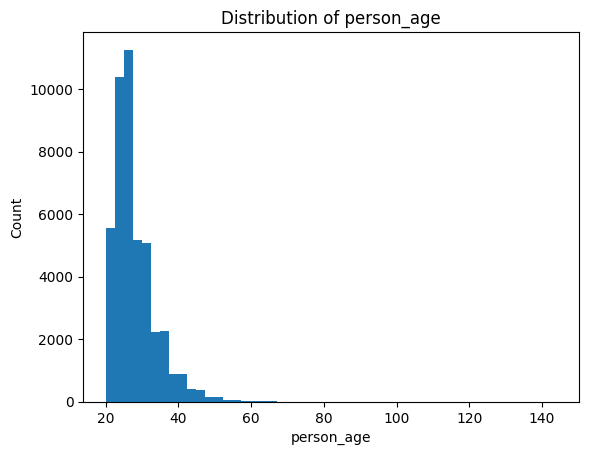

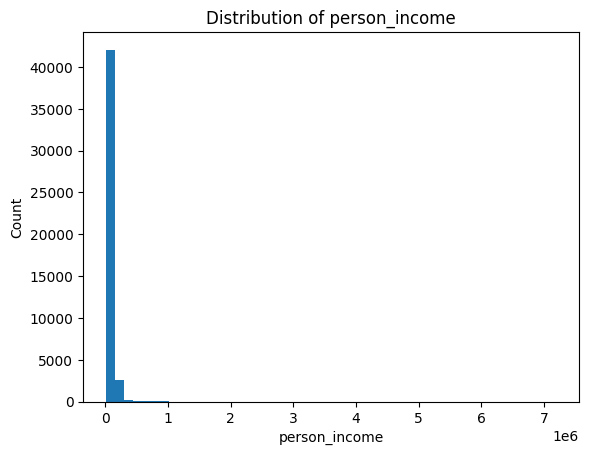

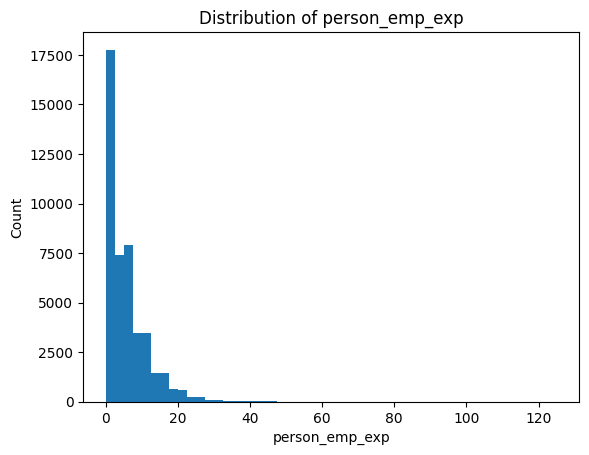

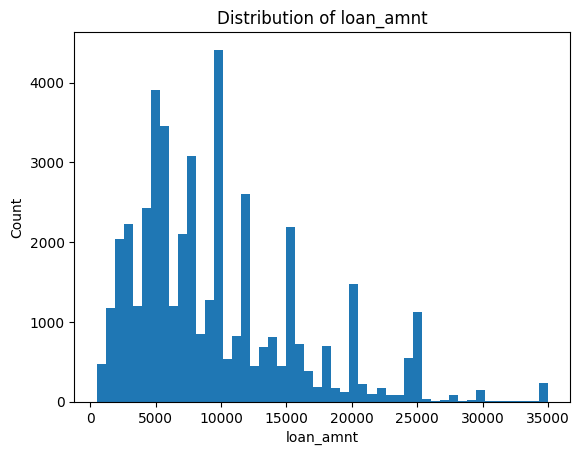

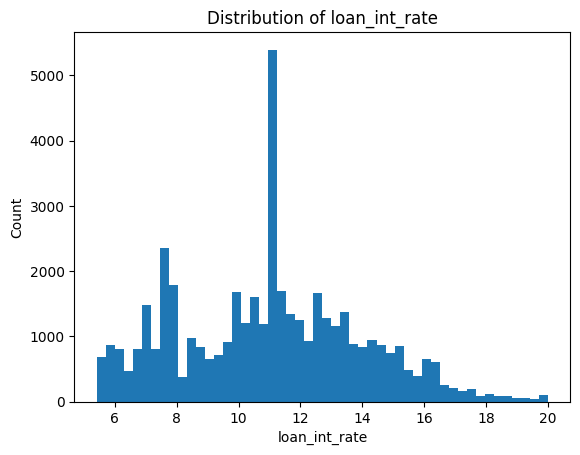

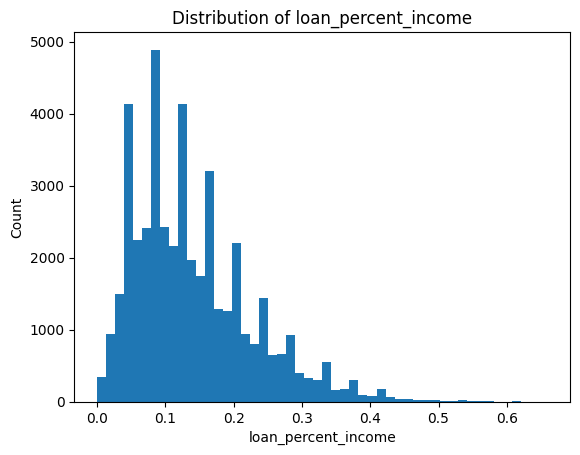

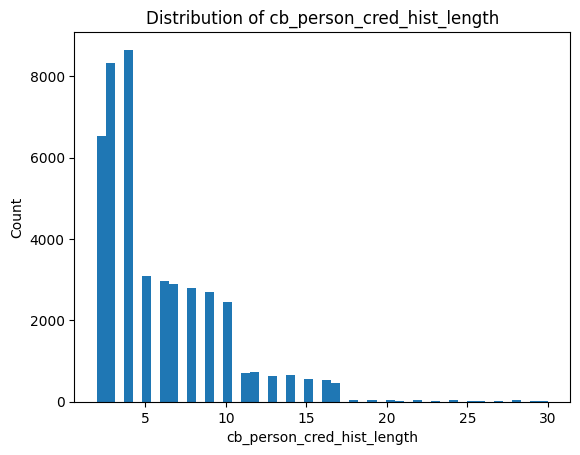

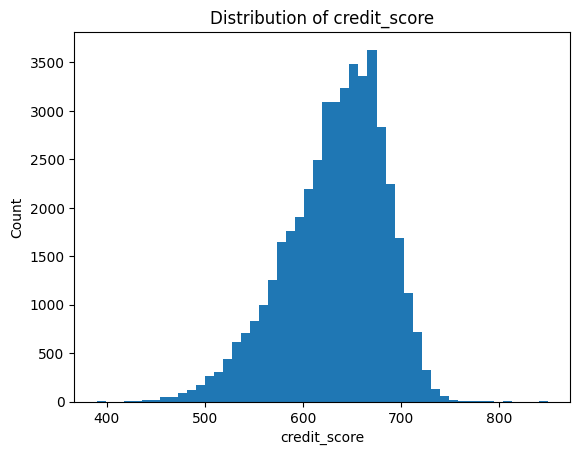

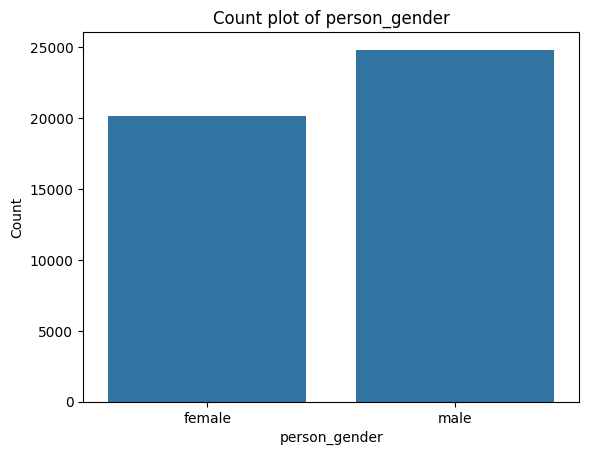

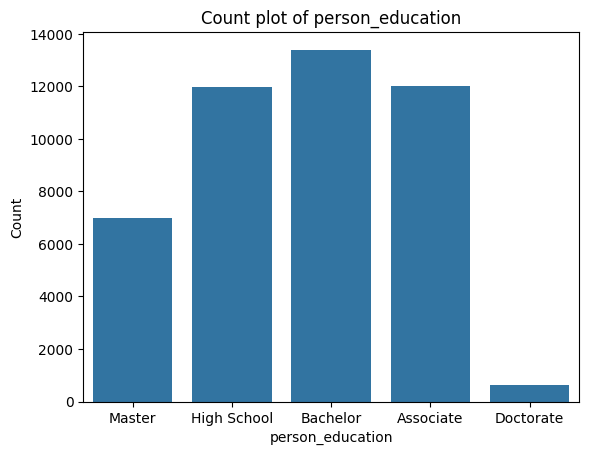

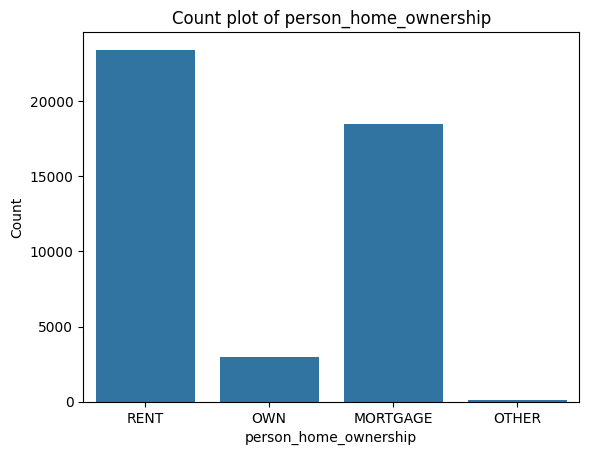

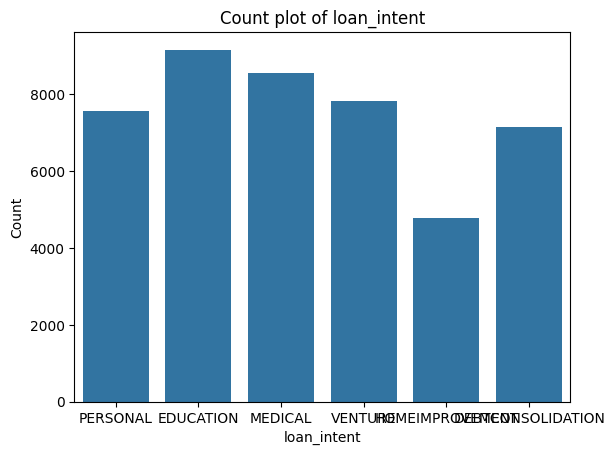

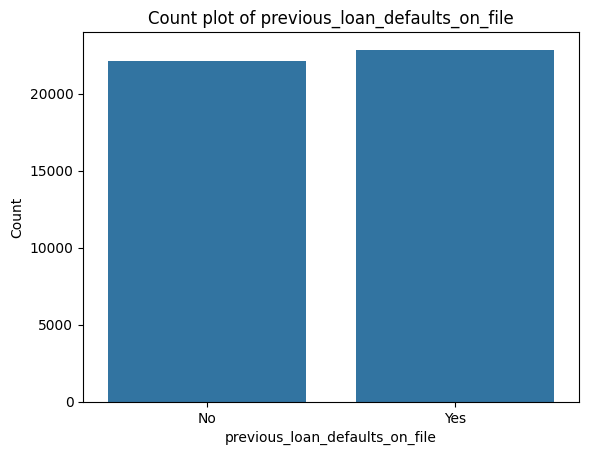

In [36]:
for col in num_cols:
    if col == 'loan_status':
        continue
    plt.figure()
    plt.hist(df[col].values, bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
for col in cat_cols:
    plt.figure()
    sb.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## 8) Correlation (numeric)

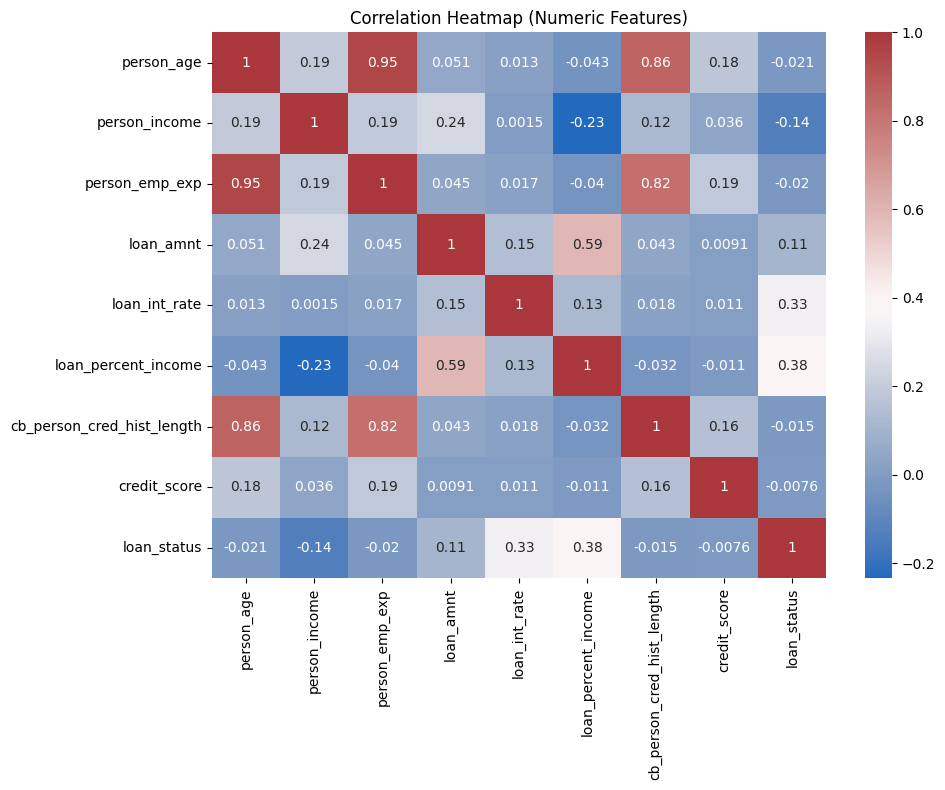

loan_status                   1.000000
loan_percent_income           0.384880
loan_int_rate                 0.332005
loan_amnt                     0.107714
credit_score                 -0.007647
cb_person_cred_hist_length   -0.014851
person_emp_exp               -0.020481
person_age                   -0.021476
person_income                -0.135808
Name: loan_status, dtype: float64

In [54]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sb.heatmap(corr, cmap='vlag',annot=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout(); plt.show()

corr['loan_status'].sort_values(ascending=False)

## 9) Normality (Shapiro–Wilk on samples)

In [55]:
shapiro_results = {}
for col in ['person_income','loan_amnt','loan_int_rate','loan_percent_income','credit_score']:
    if col in df.columns:
        sample = df[col].dropna().sample(min(5000, len(df)), random_state=RANDOM_STATE)
        stat, p = stats.shapiro(sample)
        shapiro_results[col] = {'W': stat, 'p_value': p}
pd.DataFrame(shapiro_results).T

,W,p_value
person_income,0.199644,1.189683e-90
loan_amnt,0.906854,5.052451e-48
loan_int_rate,0.982110,1.178392e-24
loan_percent_income,0.925801,2.541573e-44
credit_score,0.976105,3.600566e-28


## 10) Preprocessing

In [39]:
TARGET='loan_status'
X = df.drop(columns=[TARGET])
y = df[TARGET].values

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train:", X_train.shape, " Test:", X_test.shape)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

Train: (36000, 13)  Test: (9000, 13)


## 11) Metrics & Curves

In [40]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    # LinearSVC has decision_function but not predict_proba
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = y_pred.astype(float)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_score)
    pr_auc = average_precision_score(y_test, y_score)
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1,
            'ROC_AUC': roc_auc, 'PR_AUC': pr_auc, 'score': y_score}

def plot_roc_curves(results, y_test):
    plt.figure(figsize=(7,6))
    for res in results:
        fpr, tpr, _ = roc_curve(y_test, res['score'])
        plt.plot(fpr, tpr, label=f"{res['Model']} (AUC={res['ROC_AUC']:.3f})")
    plt.plot([0,1],[0,1],'--',label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pr_curves(results, y_test):
    plt.figure(figsize=(7,6))
    for res in results:
        prec, rec, _ = precision_recall_curve(y_test, res['score'])
        plt.plot(rec, prec, label=f"{res['Model']} (AP={res['PR_AUC']:.3f})")
    baseline = (y_test==1).mean()
    plt.hlines(baseline, 0, 1, linestyles='--', label=f'Baseline={baseline:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


## 12) Models & Tuning

In [41]:
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# 1) Logistic Regression
pipe_lr = Pipeline([('prep', preprocessor),
                    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))])
grid_lr = {'clf__C': [0.1,0.5,1,2,5,10]}
gs_lr = GridSearchCV(pipe_lr, grid_lr, scoring='roc_auc', cv=cv, n_jobs=1, verbose=0)
gs_lr.fit(X_train, y_train)
best_lr = gs_lr.best_estimator_
print("LR best:", gs_lr.best_params_)

# 2) Linear SVM
pipe_linsvm = Pipeline([('prep', preprocessor),
                        ('clf', LinearSVC(class_weight='balanced', dual='auto', max_iter=20000, random_state=RANDOM_STATE))])
grid_linsvm = {'clf__C': [0.1,0.5,1,2,5,10]}
gs_linsvm = GridSearchCV(pipe_linsvm, grid_linsvm, scoring='roc_auc', cv=cv, n_jobs=1, verbose=0)
gs_linsvm.fit(X_train, y_train)
best_linsvm = gs_linsvm.best_estimator_
print("LinearSVC best:", gs_linsvm.best_params_)

# 3) Decision Tree
pipe_dt = Pipeline([('prep', preprocessor),
                    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))])
grid_dt = {'clf__max_depth': [4, 8, 12],
           'clf__min_samples_leaf': [1, 5]}
gs_dt = GridSearchCV(pipe_dt, grid_dt, scoring='roc_auc', cv=cv, n_jobs=1, verbose=0)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_
print("DT best:", gs_dt.best_params_)

# 4) Random Forest
pipe_rf = Pipeline([('prep', preprocessor),
                    ('clf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE))])
grid_rf = {'clf__n_estimators': [200, 300],
           'clf__max_depth': [None, 12],
           'clf__min_samples_leaf': [1, 5]}
gs_rf = GridSearchCV(pipe_rf, grid_rf, scoring='roc_auc', cv=cv, n_jobs=1, verbose=0)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
print("RF best:", gs_rf.best_params_)

# 5) XGBoost
best_xgb = None
pos_rate = (y_train == 1).mean()
spw = (1 - pos_rate) / pos_rate if pos_rate > 0 else 1.0
pipe_xgb = Pipeline([('prep', preprocessor),
                        ('clf', XGBClassifier(objective='binary:logistic',
                                            eval_metric='auc',
                                            random_state=RANDOM_STATE,
                                            n_jobs=-1,
                                            tree_method='hist',
                                            scale_pos_weight=spw))])
grid_xgb = {'clf__n_estimators': [200],
            'clf__max_depth': [3, 6],
            'clf__learning_rate': [0.1],
            'clf__subsample': [0.8, 1.0],
            'clf__colsample_bytree': [0.8, 1.0]}
gs_xgb = GridSearchCV(pipe_xgb, grid_xgb, scoring='roc_auc', cv=cv, n_jobs=1, verbose=0)
gs_xgb.fit(X_train, y_train)
best_xgb = gs_xgb.best_estimator_
print("XGB best:", gs_xgb.best_params_)

# 6) CatBoost
best_cb = None
pipe_cb = Pipeline([('prep', preprocessor),
                    ('clf', CatBoostClassifier(loss_function='Logloss',
                                            eval_metric='AUC',
                                            random_seed=RANDOM_STATE,
                                            verbose=False,
                                            allow_writing_files=False,
                                            thread_count=-1))])
grid_cb = {'clf__iterations': [300, 600],
        'clf__depth': [6],
        'clf__learning_rate': [0.1]}
gs_cb = GridSearchCV(pipe_cb, grid_cb, scoring='roc_auc', cv=cv, n_jobs=1, verbose=0)
gs_cb.fit(X_train, y_train)
best_cb = gs_cb.best_estimator_
print("CatBoost best:", gs_cb.best_params_)

LR best: {'clf__C': 1}
LinearSVC best: {'clf__C': 10}
DT best: {'clf__max_depth': 8, 'clf__min_samples_leaf': 5}
RF best: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}
XGB best: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
CatBoost best: {'clf__depth': 6, 'clf__iterations': 600, 'clf__learning_rate': 0.1}


## 13) Test Metrics Table

In [42]:
models = [('LogisticRegression', best_lr),
          ('LinearSVC', best_linsvm),
          ('DecisionTree', best_dt),
          ('RandomForest', best_rf),
          ('XGBoost', best_xgb),
          ('CatBoost', best_cb)]

results = [evaluate_model(name, m, X_test, y_test) for name, m in models]
results_df = pd.DataFrame([{k:v for k,v in r.items() if k!='score'} for r in results])
display(results_df.sort_values('ROC_AUC', ascending=False).style.format({c:'{:.3f}' for c in ['Accuracy','Precision','Recall','F1','ROC_AUC','PR_AUC']}))

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
5,CatBoost,0.934,0.893,0.796,0.842,0.979,0.941
4,XGBoost,0.915,0.760,0.904,0.826,0.979,0.940
3,RandomForest,0.929,0.903,0.764,0.828,0.975,0.931
2,DecisionTree,0.899,0.728,0.867,0.792,0.965,0.895
1,LinearSVC,0.854,0.614,0.925,0.738,0.953,0.852
0,LogisticRegression,0.856,0.618,0.920,0.739,0.953,0.851


## 14) ROC & PR Curves

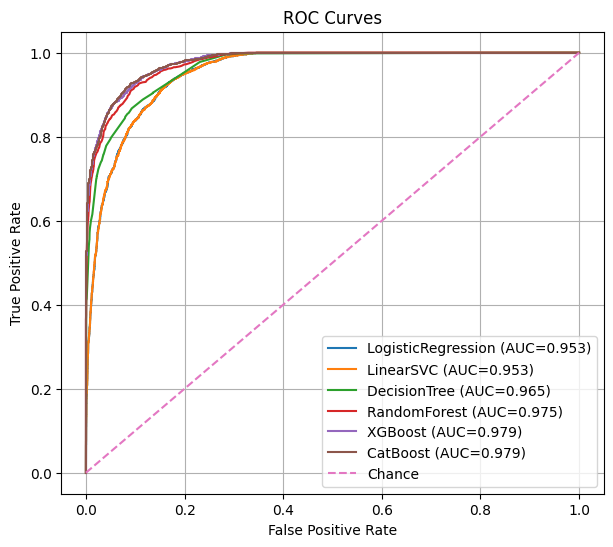

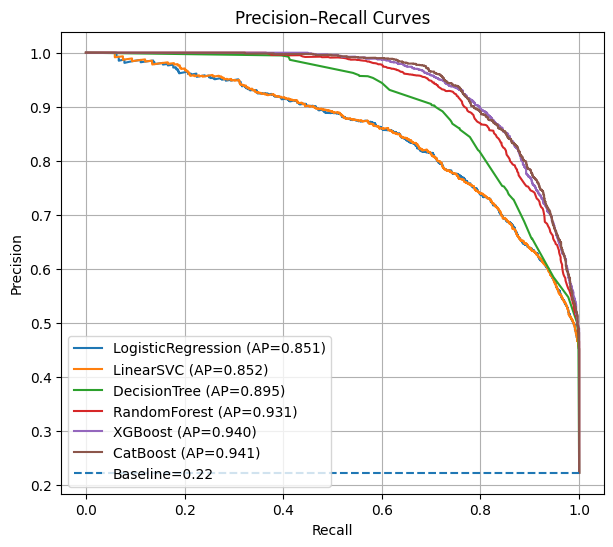

In [43]:
plot_roc_curves(results, y_test)
plot_pr_curves(results, y_test)

## 15) Feature Importances (Tree Models)

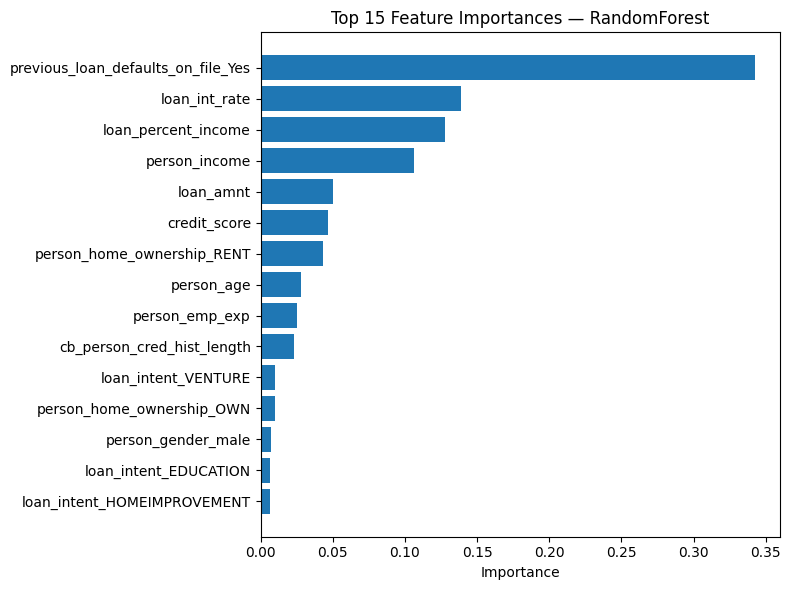

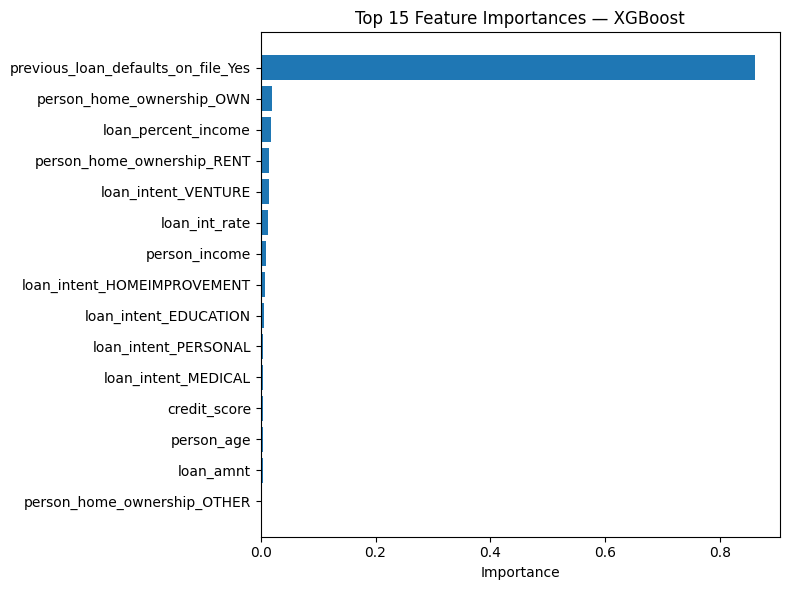

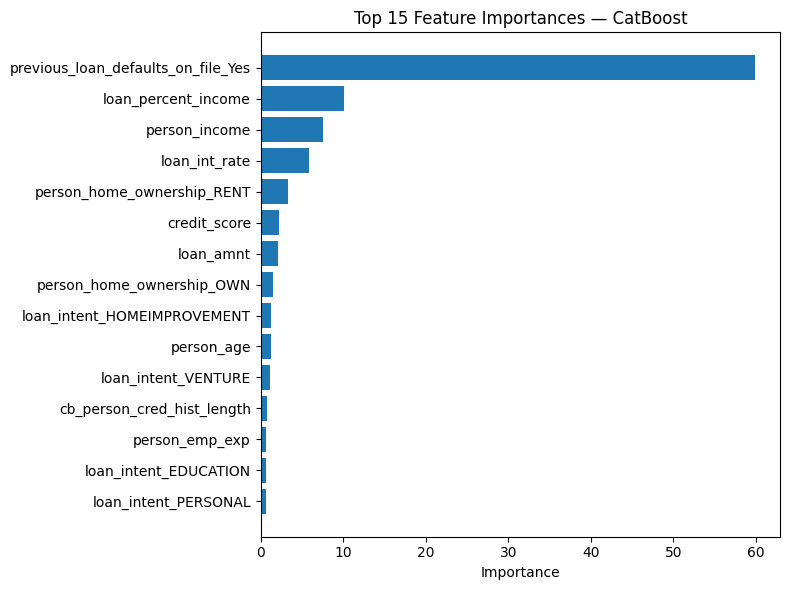

In [44]:
def get_feature_names(prep, num_cols, cat_cols):
    num_names = list(num_cols)
    onehot = prep.named_transformers_['cat']
    cat_names = list(onehot.get_feature_names_out(cat_cols))
    return num_names + cat_names

def plot_top_importances(model, model_name, num_cols, cat_cols, top_n=15):
    prep = model.named_steps['prep']
    clf = model.named_steps['clf']
    feat_names = get_feature_names(prep, num_cols, cat_cols)
    importances = clf.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(idx)), importances[idx][::-1])
    plt.yticks(range(len(idx)), [feat_names[i] for i in idx][::-1])
    plt.title(f"Top {top_n} Feature Importances — {model_name}")
    plt.xlabel("Importance"); plt.tight_layout(); plt.show()

# RandomForest
plot_top_importances(best_rf, "RandomForest", numeric_features, categorical_features)
# XGBoost
plot_top_importances(best_xgb, "XGBoost", numeric_features, categorical_features)
# CatBoost
plot_top_importances(best_cb, "CatBoost", numeric_features, categorical_features)

## 16) Conclusion — Most Effective Model

In [45]:
best = sorted(results, key=lambda r: (r['PR_AUC'], r['ROC_AUC']), reverse=True)[0]
print("Most effective model:")
for k,v in best.items():
    if k!='score':
        print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")

Most effective model:
Model: CatBoost
Accuracy: 0.9337
Precision: 0.8934
Recall: 0.7965
F1: 0.8422
ROC_AUC: 0.9789
PR_AUC: 0.9414
